In [195]:
import numpy as np
import scipy as sp
from datetime import datetime
import time
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
%matplotlib inline

In [196]:
time.ctime(time.time())


'Mon Jun  6 12:33:45 2016'

In [197]:
def correct(x):
    """Function to correct for round-off errors to 7 
       decimal places.
       
       Args:
       -----
       x    : an ndarray.
       
       Returns:
       --------
       y    : an ndarray correction of x.
    """
#   Tolarance:
    tol = 1.0e-07
    sign = np.sign(x)
    y = np.abs(x)
    
#   correct for precision:
    for i in np.arange(np.size(x)):
        if np.abs(y[i] - 1.0) < tol:
            y[i] = 1.0
        elif np.abs(y[i] - 0.0) < tol:
            y[i] = 0.0

    return y * sign
######################## simple test #################
#if __name__ == "__main__":
#    x = [1e-8, 1e-5]
#    print correct(x)

In [198]:
def mapphi(alpha, beta, phi):
    """Function to map the rotational axis:
       
       Args:
       -----
       alpha       : magnetic inclination angle w.r.t the rotatinal axis (degrees)
       beta        : line of sight closest approach to the magnetic axis (degrees)
       
       Returns:
       --------
       xlos, ylos  : The coordinates of the rotatinal plane; both the size of phi.
       
    """
    cosR = np.cos(np.deg2rad(alpha+beta)) * np.cos(np.deg2rad(alpha))
    cosR += np.sin(np.deg2rad(alpha+beta)) * np.sin(np.deg2rad(alpha)) * np.cos(np.deg2rad(phi))

    R = np.arccos(correct(cosR))

    # problems with precision for 180 degrees
    cosgamma = np.zeros_like(R)

    for i in np.arange(len(R)):
        if int(R[i]*100.0) == 180.0:
            R[i] = int(R[i]*100.0)/100.0
        if R[i] != 0.0 and R[i] != 180.0 and alpha > 0.0:
            cosgamma[i] = (np.cos(np.deg2rad(alpha+beta)) - np.cos(np.deg2rad(alpha)) * cosR[i]) \
                  /(np.sin(np.deg2rad(alpha)) * np.sin(R[i]))
        else:
             cosgamma[i] = 0.0

    cosgamma_corr = correct(cosgamma)
    gamma = np.arccos(cosgamma_corr)
    xp = R * np.sin(gamma)
    
    for i in np.arange(len(phi)):
        if phi[i] > 0.0:
            xp[i] = -xp[i]

    yp = -R * np.cos(gamma)
 
    return np.rad2deg(xp), np.rad2deg(yp)
#############################################
if __name__ == "__main__":
    phi= np.linspace(-180, 180, num=1e3, endpoint=True)
    alpha = 45
    beta = 5
    xlos, ylos =  mapphi(alpha, beta, phi)


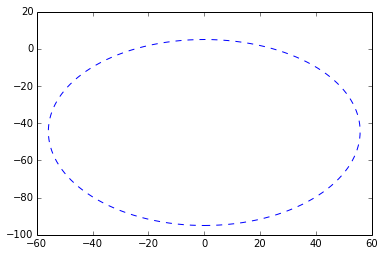

In [199]:
def los(alpha, beta):
    """Function to determine the line of sight cut across the beam.
    
       Args:
       -----
       alpha       : inclination angle
       beta        : impact parameter
       
       Returns:
       --------
       xlos        : the line of sight x-coordinates
       ylos        : the line of sight y-coordinates
       thetalos : the line of sight angle in degrees
    """

#   rotational phase:
    phi = np.linspace(-180, 180, num=1e3, endpoint=True)
    
#   line of sight x,y plane:
    xlos, ylos = mapphi(alpha, beta, phi)
    thetalos = np.arctan2(ylos, xlos) * (180 / np.pi) - 90.0
    for i in np.arange(len(thetalos)):
        if thetalos[i] < 0:
            thetalos[i] = -thetalos[i]       
            
    return xlos, ylos, thetalos
################## test ######################
if __name__ == "__main__":
    xlos, ylos, thetalos = los(alpha, beta)
    plt.plot(xlos, ylos, 'b--')

In [220]:
def emission_height(P, freq, ncomp, npatch, iseed, hmin, hmax):#, spec):
    """Function to determine emission heights given hmin and hmax. Allowed emision heights for young 
       pulsars range between [950, 1000] and between [20, 1000] for old pulsars.
    
       Args:
       -----
       P      : rotational period (in seconds).
       freq   : frequency (in GHz).
       hmin   : minimum emission height (in km).
       hmax   : maximum emission height (in km).
       ncomp  : integer number of component.
       iseed  : integer seed for a pseudo-random number generator.
       spec   : spectral index.
       
       Returns:
       --------
       H      : emission heights (in km).
    """

    #np.random.seed(datetime.now())
    #np.random.seed(float(time.time()))
    np.random.seed(iseed)

    num_H = ncomp # number of discrete emission height
    
#   If height range is not specified:
    if hmin == None and hmax == None:
        
        # emission height for a short period pulsar: only one emission height 
        if P <= 0.15:
            hmin = 950 
            hmax = 1000
            H = np.random.uniform(hmin, hmax, size=1)

        elif P > 0.15:
            hmin = 20 
            hmax = 1000
            H = np.random.uniform(hmin, hmax, size=num_H) 
                
#   For specified height range:
    else:
        if P < 0.15: # only one emission region
            H = np.random.uniform(hmin, hmax, size=1)
            H = hmin
        if P > 0.15: 
            H = np.random.uniform(hmin, hmax, size=num_H)
            #H = [hmin, hmax]
            #H = np.array(H)
            
#   Frequency dependence:
    gamma = 0.86    # with rho \prop mu^-0.43 for (error +/- 0.06 ref: fig.12 Hassall et al. 2012.)
    H_mu = 0.6*H * freq**(-gamma) + 0.4*H # frequency dependence
    #H_mu = H * freq**(-gamma) + H0
    #print "H_mu",H_mu

            
    return H

########################### simple test #############################
if __name__ == "__main__":
    P = 0.2
    freq = 0.8
    hmin = 800
    hmax = 1000
    ncomp = 2
    npatch = 10
    iseed = 1000
    heights = emission_height(P, freq, ncomp, npatch, iseed, hmin, hmax)#, spec=None)
    #heights = emission_height(P, ncomp, iseed, hmin, hmax)
    print "heigths = ",heights,"km"  

heigths =  [ 930.71791709  823.00138862] km


In [221]:
from scipy import constants
#import emission_height

def rho(P, heights):
    """Function to determine the opening angle rho given the rotational period and emission height.
       
    
       Args:
       -----
       P         : rotational period (seconds)
       heights   : emission heights (km)
       
       Returns:
       --------
       rho       : the opening angle (degrees)
       
    """

#   opening angle (eqn 3.29, Lorimer and Kramer 2005):
    rho = np.rad2deg(np.sqrt((9 * np.pi * heights) / (2 * (constants.c / 1e3) * P))) 
    
    return rho

#################### simple test #####################################
if __name__ == "__main__":
    opa = rho(P, heights)
    print "opening angle =",opa,"degrees"

opening angle = [ 26.84030914  25.23938453] degrees


In [222]:
def patch_width(P, heights):
    """Function to calculate the width of a patchy emission region 
       within a pulsar beam at a given height.
    
       Args:
       -----
       P             : rotational period (seconds).
       heights       : emission heights (km).
      
       
       Returns:
       --------
       patchwidths   : the width of the patchy emission region (degrees).
       
    """   
    
#   width of the patch (eqn 3, KJ2007):
    patchwidths = 2.45 * 0.2 * np.sqrt(heights / ( 10 * P))

#   valid at 1 GHz, but can be applied at LOFAR frequencies, maintaining
#   the same dependence, if the impact angle β ≪ ρcore; sin α
#   should be ignored for orthogonal rotators (α ∼ 90◦). (M. Pilia et. al, 2015)
    
    return patchwidths
#################### simple test ################################################
if __name__ == "__main__":
    patchwidths = patch_width(P, heights)
    print "patch width =",patchwidths,"degrees"


patch width = [ 10.5703683    9.93988515] degrees


In [223]:
def patch_center(P, heights, npatch):
    """Function find centres of the patches
       
       Args:
       -----
       P       : rotatinal period
       heights : emission heights (in km).       
       
       Returns:
       --------
       centerx : the patch center projection on the x-axis 
       centery : the patch center projection on the y-axis 
    """
    
#   opening angle:    
    opa = rho(P, heights) 
    
#   initialize the array:
    centerx = []
    centery = []
    #np.random.seed(datetime.now())
    
    for comp in opa: #for each emission height (comp!)
#       find the center of the patch
        tempCenterX = []
        tempCenterY = []
        theta = 2 * np.pi * np.random.random(npatch)

        for i in np.arange(npatch):
            tempCenterX.append(comp * np.sin(theta[i]))
            tempCenterY.append(comp * np.cos(theta[i]))
                

        centerx.append(tempCenterX)
        centery.append(tempCenterY)
        
    print "acive patches: " ,npatch
        
    return centerx, centery 

########################### simple test ###########################
if __name__ == "__main__":
    cx, cy = patch_center(P, heights, npatch)
    for i in range(len(cx)):
        print 'height %i:\n'%i, cx[i], '\n', cy[i], '\n'#, rho[i]

acive patches:  10
height 0:
[-8.2487303436837696, 2.9970258512039147, -19.277720151771085, 26.092107681686286, 6.7907599631358861, 16.156639966130392, 26.689708185907065, -22.503372730832279, 25.870344395591957, -26.810270518850647] 
[25.541351616695643, -26.672458280737938, 18.675430395053535, 6.2931797541289116, 25.967051696593536, -21.432806155408784, 2.8393083033752791, 14.628752866451896, 7.1503479316711775, -1.2694839095231953] 

height 1:
[15.823508907142482, 22.987341469308536, -25.218592707471615, 10.686402729147947, -16.650954746034074, -7.3995067298473955, -10.582058923612758, 12.789020053606709, 4.570661544464989, -2.8440948880093497] 
[-19.663242292122813, 10.421548049428782, -1.0242623823045647, 22.865417736914495, 18.967662945620635, 24.130350841379986, 22.913894485886335, -21.759308298785374, 24.822078571688824, 25.078629464967651] 



In [224]:
def aberration(heights):
    """Function to determine the abberation offest due to the curvature of the magnetic field lines.
    
       Args:
       -----
       heights     : emission heights 

       Returns:
       --------
       ab_ofsetx   : ofset of the projected x coordinates
       ab_ofsety   : ofset of the projected y coordinates
       
    """
    
#   aberration time scale in seconds:
    ab_time = heights / (constants.c / 1e3)
    ab_deg = (ab_time / P) * 360
    ab_ofsetx, ab_ofsety = mapphi(alpha, 0.0, 5*ab_deg)
            
    return ab_ofsetx, ab_ofsety

########################################## 
if __name__ == "__main__":
    ab_ofsetx, ab_ofsety = aberration(heights)
    print ab_ofsetx, '\n', ab_ofsety
    

[-19.36098034 -17.19734217] 
[-3.40586748 -2.66329856]


In [225]:
#def sc_time(freq, frac, P):
#    """Function to determine the scattering time scale.
#       It assumes a canonical period (1 s) and a maximum scattering time as fraction/function of this period.
       
#       Args:
#        -----
#        freq   :   frequency (in GHz) (array)
#        frac   :   fraction that gives the maximum scattering.
#        P      :   period (seconds)
#    
#       Return:
#       -------
#       tau     :   the frequency dependent time scale in sec (array).
       
#    """
    #freq = np.asanyarray(freq)
    #low_freq = min(freq)
    #tau_max = frac * P # largest scattering time
    
    # scattering time scales as freq^-4 with kappa the proportionality constat.
    # determine the proportinality constant kappa (tau = kappa * freq^-4):
    # the lowest frequency will correspond to the highest scattering time:
    #kappa = tau_max / (low_freq ** (-4)) 
    #kappa = tau_max / (freq ** (-4)) 
    
    #Now find the scattering time scale for each frequency:
    #tau = kappa * freq ** (-4)
    
    #return tau
#######################################3
#if __name__ == "__main__":
#    frac = 0.3
#    tau = sc_time(P, freq, frac)
#    print tau



In [226]:
def sc_time(freq, dm):
    """Function to determine the scattering time scale.

        Args:
        -----
        freq   :   frequency (in GHz) (array)
        dm     :   dispersion measure (pc cm^-3).
    
       Return:
       -------
       tau     :   the frequency dependent time scale in sec (array).

    """
#   tau = scattering time scale as in Bhat et al. (2004)     
    log_tau = -6.46 + 0.154 * np.log10(dm) + 1.07 * (np.log10(dm))**2 - 3.86 * np.log10(freq)*np.random.rand()
    tau = 10**log_tau * 1e3 #(tau in seconds)

    return tau
##################################################################################################
if __name__ == "__main__":
    print "scattering %.2f" %sc_time(freq, dm) + " s" 

scattering 0.09 s


In [227]:
def broadening(P, tau):
    """Function to determine the broadening capacity given the broadening time scale.
    
       Args:
       -----
       tau        : scattering time scale (in seconds)
       P          : period (in seconds)
       
       Return:
       -------
       broad_func : broadening function (1/sec)
       
    """
    #print tau
    #broad_func = np.zeros_like(tau)
    #for i in np.arange(len(tau)):
    #    broad_func +=  (1/tau[i]) * np.exp(- (P / tau[i]))
    
    t = np.linspace(0, 5*P, num=1e3, endpoint=True)
    broad_func = 1/tau * np.exp(- (t/ tau))
    
    return broad_func

################# simple test ##############################
if __name__ == "__main__":
    bf = broadening(P, tau)
#    plt.plot(tau, bf)
#print bf

0.129023232819 0.2
1000 1000


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


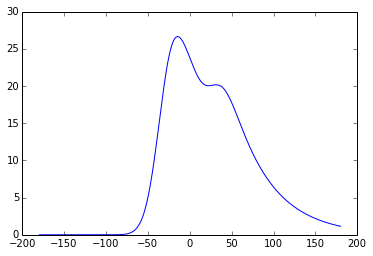

In [228]:
def scatter(prof, bf):
    """
    Function to scatter the profile; convolves the profile with the broadening function.
    
    Args:
    -----
    prof   : an array of the profile
    bf     : broadening function (an array)

    Returns:
    --------
    scatter: convolution of the profile.

    """
    
    conv = np.convolve(prof, bf)
    profint = np.sum(prof)
    convint = np.sum(conv)
    sc_prof = conv * (profint/convint)
    
    return sc_prof[0:1e3]
##########################################
if __name__ == "__main__":
    tau = sc_time(freq, dm)
    dm = 25
    print tau, P
    bf = broadening(P, tau)
    conv = scatter(prof, bf)
    x = np.linspace(-180, 180, num=len(conv))
    print len(x), len(conv)
    plt.plot(x, conv)

In [229]:
def dispersion(freq, dm):
    """Function to determine the dispersion time scale given frequency and dispersion measure.
    
       Args:
       -----
       freq    : an array of frequency in (GHz)
       dm      : an array dispersion measure (pc cm^-3)
       
       Returns:
       --------
       dtime   : dispersion time scale (s)
       
    """
    D = 4.148808 * 1e3 # Dispersion constant in MHz^2 pc^-1 cm^-3 (Assumes the NE2001 model)
    dtime = D * (dm / (freq * 1e3)**2)
    
    return dtime

#################### simple test #########################################################
#if __name__ == "__main__":
    #print "Dm =" + str(100) + ", freq=" + str(freq) + ", time=" + str(dispersion(freq, 100))
    #print "Dm =" + str(100) + ", freq=" + str(0.2) + ", time=" + str(dispersion(0.2, 100))
    #print "Dm =" + str(100) + ", freq=" + str(0.05) + ", time=" + str(dispersion(0.05, 100))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:21: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.0958702548085 0.2


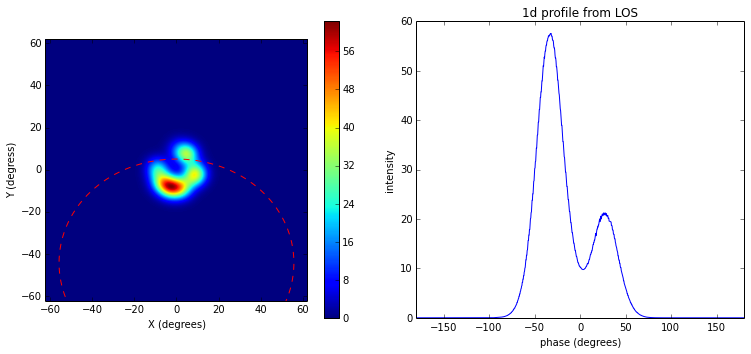

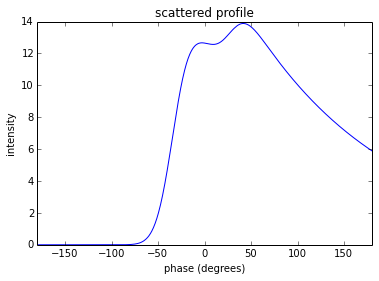

In [230]:
def plotpatch(P, alpha, beta, heights, centerx, centery, snr, do_ab):
    """Function to plot the patches for a given height range. Using a 2d gaussian
    
       Args:
       -----
       P       : rotational period (seconds)
       alpha   : inclination angle (degrees)
       beta    : impact parameter (degrees)
       heights : emission heights (in km)
       centerx : the patch center projection on the x-axis 
       centery : the patch center projection on the y-axis
       snr     : signal to noise ratio
       
       Returns:
       --------
       A plot of the patches projected on to observational plane.
    
    """    
    
#   initialize parameters:
    xmin = -180.
    xmax = 180.
    xnum = 1e3
    ymin = -180.
    ymax = 180.
    ynum = 1e3
    dx = (xmax - xmin)/xnum
    dy = (ymax - ymin)/ynum
    x = np.linspace(xmin, xmax, num=xnum, endpoint=True)
    y = np.linspace(ymin, ymax, num=ynum, endpoint=True)
    X,Y = np.meshgrid(x,y)
    gauss = np.zeros(len(x))
    Z = np.zeros_like(X)
    prof_los = np.zeros_like(gauss)

#   find the width of the patches:
    patchwidths = patch_width(P, heights)
      
    
#   An arbitrary peak of the profile:
    peak = 10. 
    
#   Get the line of sight and the aberration ofset:
    xlos, ylos, thetalos = los(alpha, beta)
    ab_ofsetx, ab_ofsety = aberration(heights)
    
    for cid, comp in enumerate(heights):
#       widths for circular patches: 
        #print cid, comp
        sigmax = patchwidths[cid]
        sigmay = patchwidths[cid]
    
#       center of the patch:
        patchCenterX = centerx[cid]
        patchCenterY = centery[cid]
        
#       2D patch:
        # with aberration:
        for pc in zip(patchCenterX, patchCenterY):
            #without aberration:
            if do_ab == None: 
                Z += peak * np.exp(-((X - pc[0] )**2 / (2 * sigmax**2) + (Y - pc[1])**2 / (2 * sigmay**2)))
        
            #with aberration:
            else:
                Z += peak * np.exp(-((X - pc[0] - ab_ofsetx[cid] )**2 / (2 * sigmax**2) + (Y - pc[1] - ab_ofsety[cid])**2 / (2 * sigmay**2)))
                
#   1D profile from 2D patch, closest to the line of sight (select nearest neighbors):
    
    ZxIdx = np.array(xlos/dx, dtype=int) - int(xnum/2) # x index
    ZyIdx = np.array(ylos/dy, dtype=int) - int(ynum/2) # y index
    prof = Z[ZxIdx, ZyIdx]

    

#   Apply scattering:
    # 1. Find the scattering time:
    tau = sc_time(freq, dm)
    
    # 2. Find the function that broadens the profile:
    bf = broadening(tau, P)
    
    # 3. Scatter the profile:
    sc_prof = scatter(prof, bf)
        
#   add noise: a normal distibution with zero mean, and std dev = 1
    if snr == None:
        prof = prof # profile without noise
        
    else:
        sigma_s = sigmax #std dev of the profile
        sigma_n = sigmax/np.sqrt(snr)#std dev of the noise
        mean_n = (sigmax**2) * np.sqrt(snr)     
        noise = np.random.normal(mean_n, sigma_n, 1e3)
        prof = prof + noise
    
#   profile plot:

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 2)
    plt.title("1d profile from LOS")
    plt.xlabel("phase (degrees)")
    plt.ylabel("intensity")
    plt.xlim(xmin, xmax)
    plt.tight_layout()
    #time = np.linspace(0, P, num=1e3, endpoint=True)
    #plt.plot(time, prof)
    plt.plot(x, prof)

    
#   patchy emission region:

    plt.subplot(1, 2, 1)
    plt.plot(xlos, ylos, '--r')
    plt.imshow(Z, extent=[-np.amax(Z),np.amax(Z),-np.amax(Z),np.amax(Z)])#, cmap=cm.gray)
    plt.xlabel('X (degrees)')
    plt.ylabel('Y (degress)')
    plt.colorbar()

#   scattered profile
    plt.figure()
    plt.plot(x, sc_prof)
    plt.title("scattered profile")
    plt.xlabel("phase (degrees)")
    plt.ylabel("intensity")
    plt.xlim(xmin, xmax)
    print tau, P
               
    return prof
############################ simple test ##########################
if __name__ == "__main__":
    snr = 1e3
    prof = plotpatch(P, alpha, beta, heights, cx, cy, snr=None, do_ab=None)